In [4]:
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

import os
import numpy as np
import pandas as pd
import seaborn as sns
import random

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.paa import PAA
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

from scipy.spatial.distance import euclidean

from datetime import datetime
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import sys

from sktime.distances import distance
from tslearn.metrics import dtw as tsldtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from dtaidistance import dtw
import random

from sklearn.neighbors import sort_graph_by_row_values
import scipy.sparse as sp

from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
def load_npy(time_series):
    with open(time_series, 'rb') as f:
        return np.load(f)

def preparation_ts():
    dir_path = 'time_series/'
    len_threshold = 1280  # soglia entro la quale viene considerata la ts
    
    X, y, ids = [], [], []

    for file in os.listdir(dir_path):
        if os.path.splitext(file)[1] != '.npy':
            continue

        split = file.split("_")  # suddivide il nome del file
        ids.append(split[0])  # track_id
        y.append(split[1][:-4])  # genre
        ts = load_npy(os.path.join(dir_path, file))
    
        if len(ts) > len_threshold:
            ts = ts[:len_threshold]
        else:
            pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
            ts = np.append(ts, pad)

        X.append([ts])

    X, y, ids = np.array(X), np.array(y), np.array(ids)
    
    # Ridimensiona X in base al numero effettivo di serie temporali caricate
    X = X.reshape((len(X), 1, len_threshold))
    
    np.savez('X_y_ids', X=X, y=y, ids=ids)

    # Ricarica gli array da file .npz utilizzando np.load
    loaded_data = np.load('X_y_ids.npz')
    X, y, ids = loaded_data['X'], loaded_data['y'], loaded_data['ids']
    
    return X, y, ids

X, y, ids = preparation_ts()

# Definisci la variabile all_ts
all_ts = X.tolist()  

In [6]:
def approximate(ts, approx):
    return approx.fit_transform(ts)

paa = PAA(100)

X_paa = np.array([[approximate(np.expand_dims(ts, axis=1), paa)[:, 0]] for ts in X])

y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 1, 1, 100) (2000, 1, 1, 100) (8000,) (2000,)


In [7]:
X_train_reshaped = np.squeeze(X_train)

# Creare un DataFrame con i valori delle serie temporali e il genere
df = pd.DataFrame(X_train_reshaped)
df["genre"] = y_train

# Aggiungere gli Id al DataFrame
df["Id"] = ids[:X_train.shape[0]]  # Assicurati che ids sia della stessa lunghezza di X_train

X_test_reshaped = np.squeeze(X_test)

# Creare un DataFrame con i valori delle serie temporali e il genere
df = pd.DataFrame(X_test_reshaped)
df["genre"] = y_test

# Aggiungere gli Id al DataFrame
df["Id"] = ids[:X_test.shape[0]]

In [8]:
# Visualizza i duplicati nella colonna 'id'
duplicated_ids = df[df.duplicated('Id')]

# Rimuovi i duplicati mantenendo la prima occorrenza
df = df.drop_duplicates(subset='Id', keep='first')

In [9]:
X = df.iloc[:, :-2].values
y = df.iloc[:, -2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

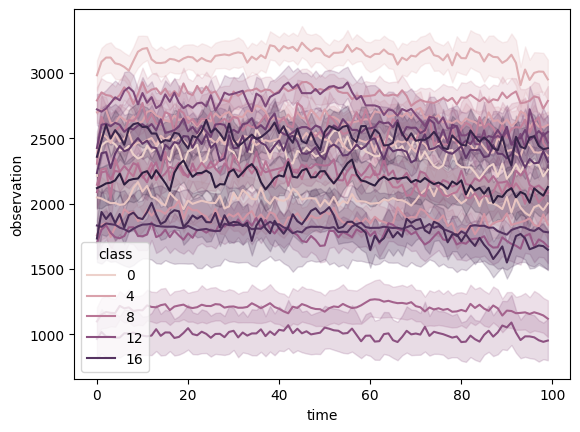

In [10]:
df = pd.DataFrame(np.squeeze(X_train))
df["class"] = y_train
df_melt = df.melt(value_name="observation", var_name="time", id_vars="class")
sns.lineplot(df_melt, x="time", y="observation", estimator="mean", hue="class")
plt.show()

In [11]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

In [12]:
st = ShapeletTransformClassifier()

In [13]:
%%time
st.fit(X_train_scaled, y_train)
y_pred = st.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.10      0.13      0.11        15
           1       0.14      0.04      0.07        23
           2       0.00      0.00      0.00        26
           3       0.50      0.32      0.39        22
           4       0.00      0.00      0.00        23
           5       0.05      0.06      0.06        16
           6       0.23      0.32      0.27        19
           7       0.33      0.26      0.29        27
           8       0.41      0.47      0.44        19
           9       0.15      0.11      0.12        19
          10       0.17      0.60      0.27        10
          11       0.38      0.18      0.24        28
          12       0.32      0.57      0.41        14
          13       0.33      0.47      0.39        17
          14       0.14      0.17      0.15        24
          15       0.15      0.37      0.22        19
          16       0.18      0.20      0.19        10
          17       0.11    

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

In [15]:
rst = RandomShapeletTransform(n_shapelet_samples=1576 , max_shapelets=None, min_shapelet_length=3, max_shapelet_length=None, n_jobs=-1)

In [16]:
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np

# Validate data
assert not np.any(np.isnan(X_train_scaled)), "X_train_scaled contains NaN values"
assert not np.any(np.isnan(y_train)), "y_train contains NaN values"

# Initialize the ShapeletTransformClassifier
st = ShapeletTransformClassifier()
print("Fitting ShapeletTransformClassifier...")
st.fit(X_train_scaled, y_train)
y_pred = st.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Initialize the RandomShapeletTransform with default parameters
rst = RandomShapeletTransform(n_jobs=-1)

print("Fitting RandomShapeletTransform...")
try:
    rst.fit(X_train_scaled, y_train)
    X_train_transformed = rst.transform(X_train_scaled)
    X_test_transformed = rst.transform(X_test_scaled)
    
    # Train a classifier on the transformed data
    clf = DecisionTreeClassifier()
    clf.fit(X_train_transformed, y_train)
    y_pred_rst = clf.predict(X_test_transformed)
    print(classification_report(y_test, y_pred_rst))
except ZeroDivisionError as e:
    print(f"Error during RandomShapeletTransform fitting: {e}")


Fitting ShapeletTransformClassifier...
              precision    recall  f1-score   support

           0       0.10      0.13      0.11        15
           1       0.17      0.04      0.07        23
           2       0.27      0.12      0.16        26
           3       0.30      0.27      0.29        22
           4       0.15      0.09      0.11        23
           5       0.11      0.12      0.12        16
           6       0.15      0.26      0.19        19
           7       0.26      0.19      0.22        27
           8       0.38      0.47      0.42        19
           9       0.00      0.00      0.00        19
          10       0.18      0.60      0.27        10
          11       0.24      0.14      0.18        28
          12       0.36      0.64      0.46        14
          13       0.30      0.47      0.36        17
          14       0.14      0.17      0.15        24
          15       0.18      0.42      0.25        19
          16       0.17      0.10      0.1